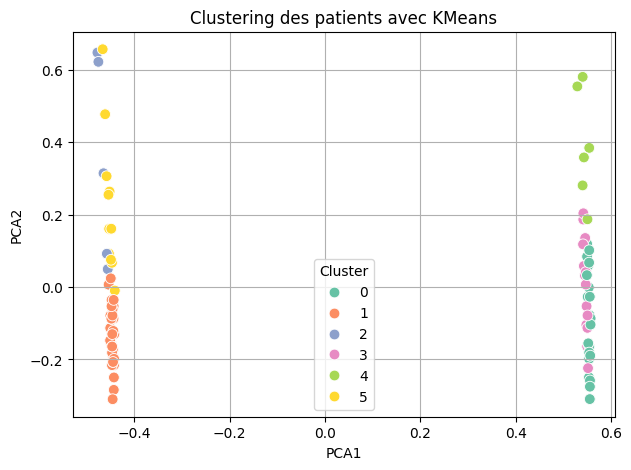

Statistiques moyennes pour les clusters - KMeans :
         Nb_Diagnoses  Nb_Procedures  Gender_M
Cluster                                       
0           13.000000       1.583333       1.0
1           10.722222       1.916667       0.0
2           11.000000      11.285714       0.0
3            9.133333       5.000000       1.0
4           24.500000       8.166667       1.0
5           21.250000       6.750000       0.0
------------------------------------------------------------
--- Évaluation du clustering KMeans ---
R² (variance expliquée) : 0.7084
MAE : 0.0652
Silhouette Score : 0.3899


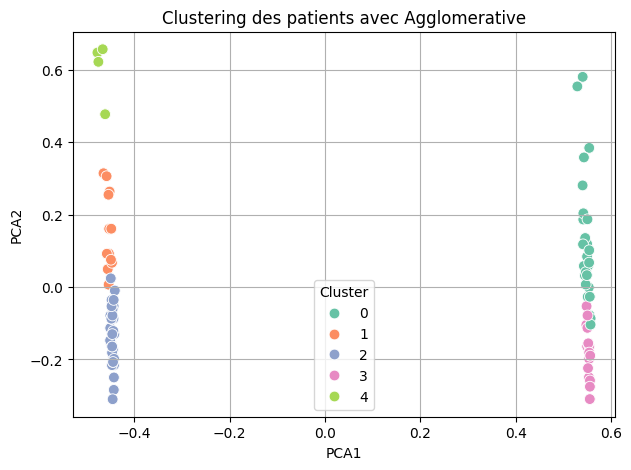

Statistiques moyennes pour les clusters - Agglomerative :
         Nb_Diagnoses  Nb_Procedures  Gender_M
Cluster                                       
0           17.111111       4.888889       1.0
1           15.285714       6.642857       0.0
2           11.111111       1.750000       0.0
3            7.444444       1.666667       1.0
4           20.800000      14.600000       0.0
------------------------------------------------------------
--- Évaluation du clustering Agglomerative ---
R² approx (variance expliquée) : 0.8926
MAE moyen intra-cluster : 0.0727
Silhouette Score : 0.4003
Davies-Bouldin Score : 0.9940


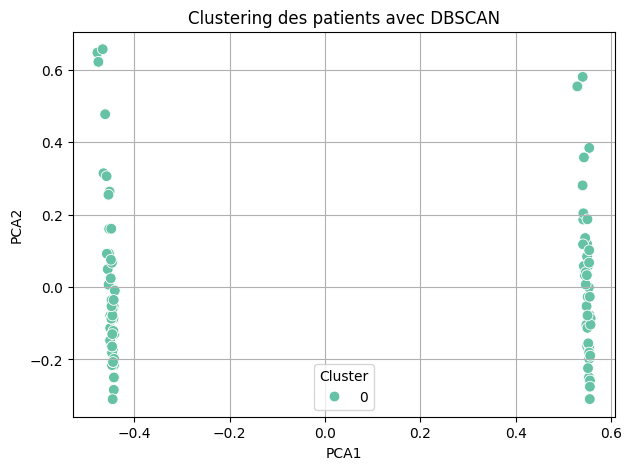

Statistiques moyennes pour les clusters - DBSCAN :
         Nb_Diagnoses  Nb_Procedures  Gender_M
Cluster                                       
0               13.14           3.91      0.45
------------------------------------------------------------
--- Évaluation du clustering DBSCAN ---
DBSCAN n'a pas généré de clusters valides (seulement du bruit).


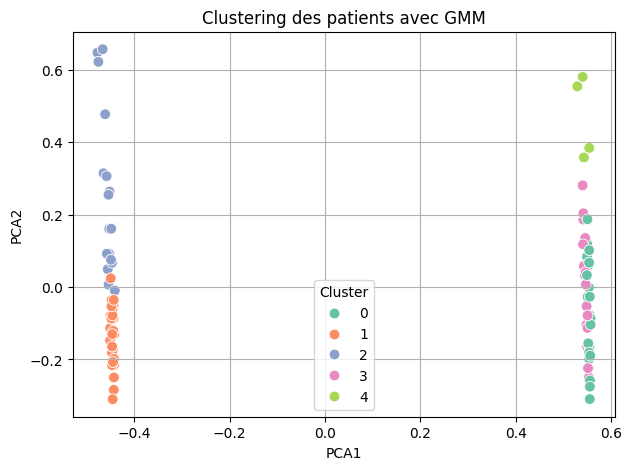

Statistiques moyennes pour les clusters - GMM :
         Nb_Diagnoses  Nb_Procedures  Gender_M
Cluster                                       
0           13.750000       1.708333       1.0
1           10.771429       1.800000       0.0
2           17.050000       8.300000       0.0
3            9.294118       5.000000       1.0
4           27.000000       9.000000       1.0
------------------------------------------------------------
--- Évaluation du clustering GMM ---
R² (variance expliquée) : 0.6390
MAE : 0.0715
Silhouette Score : 0.3766


c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


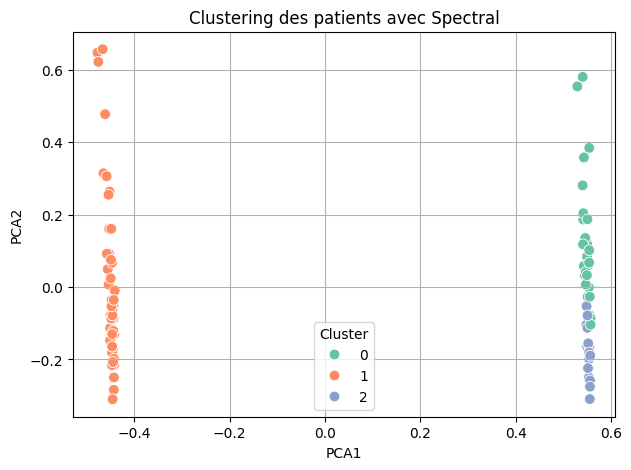

Statistiques moyennes pour les clusters - Spectral :
         Nb_Diagnoses  Nb_Procedures  Gender_M
Cluster                                       
0           17.111111       4.888889       1.0
1           13.054545       4.163636       0.0
2            7.444444       1.666667       1.0
------------------------------------------------------------
--- Évaluation du clustering Spectral ---
R² approx (variance expliquée) : 0.8067
MAE moyen intra-cluster : 0.0772
Silhouette Score : 0.5382
Davies-Bouldin Score : 0.7779

🎯 Interprétation dynamique des résultats :
✅ Le modèle **Agglomerative** est le plus performant avec un R² de **0.8926**.
Cela signifie qu’il explique le mieux la variance entre les groupes de patients.
Ce modèle est donc le plus adapté à cette segmentation basée sur les diagnostics et procédures.

📊 Classement des algorithmes par R² décroissant :
- Agglomerative : R² = 0.8926
- Spectral : R² = 0.8067
- KMeans : R² = 0.7084
- GMM : R² = 0.6390


In [2]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error, silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Connexion à la base PostgreSQL
USERNAME = os.getenv("POSTGRES_USER", "postgres")
PASSWORD = os.getenv("POSTGRES_PASSWORD", "123456789")
HOST = os.getenv("POSTGRES_HOST", "localhost")
PORT = os.getenv("POSTGRES_PORT", "5432")
DATABASE = os.getenv("POSTGRES_DB", "DBM")
DATABASE_URL = f"postgresql+psycopg2://{USERNAME}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}"
engine = create_engine(DATABASE_URL, connect_args={'client_encoding': 'LATIN1'})

# Chargement des tables
patients = pd.read_sql('SELECT * FROM "Dim_Patient"', engine)
diagnosis = pd.read_sql('SELECT * FROM "Dim_Diagnosis"', engine)
procedure = pd.read_sql('SELECT * FROM "Dim_Procedure"', engine)

# Harmonisation des types de clé
patients["hadm_id"] = patients["hadm_id"].astype(str)
diagnosis["hadm_id"] = diagnosis["hadm_id"].astype(str)
procedure["hadm_id"] = procedure["hadm_id"].astype(str)

# Comptage des diagnostics et procédures par hadm_id
diag_count = diagnosis.groupby("hadm_id")["diagnosis_id"].nunique().reset_index(name="Nb_Diagnoses")
proc_count = procedure.groupby("hadm_id")["icd9_code"].nunique().reset_index(name="Nb_Procedures")

# Fusion avec les patients via hadm_id
df = patients.merge(diag_count, on="hadm_id", how="left")
df = df.merge(proc_count, on="hadm_id", how="left")
df["Nb_Diagnoses"] = df["Nb_Diagnoses"].fillna(0)
df["Nb_Procedures"] = df["Nb_Procedures"].fillna(0)

# Encodage du sexe
df["Gender"] = df["Gender"].fillna("Unknown").astype(str)
df = pd.get_dummies(df, columns=["Gender"], drop_first=True)

# Normalisation
features = ["Nb_Diagnoses", "Nb_Procedures"] + [col for col in df.columns if "Gender_" in col]
X = df[features]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df["PCA1"], df["PCA2"] = X_pca[:, 0], X_pca[:, 1]

# Clustering
clustering_models = {
    "KMeans": KMeans(n_clusters=6, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=5),
    "DBSCAN": DBSCAN(eps=1.2, min_samples=5),
    "GMM": GaussianMixture(n_components=5, random_state=42),
    "Spectral": SpectralClustering(n_clusters=3, random_state=42, affinity='nearest_neighbors')
}

r2_scores = {}

for name, model in clustering_models.items():
    try:
        labels = model.fit_predict(X_scaled)
        df["Cluster"] = labels

        # Visualisation
        plt.figure(figsize=(7, 5))
        sns.scatterplot(data=df, x="PCA1", y="PCA2", hue="Cluster", palette="Set2", s=60)
        plt.title(f"Clustering des patients avec {name}")
        plt.grid(True)
        plt.show()

        # Statistiques moyennes
        print(f"Statistiques moyennes pour les clusters - {name} :")
        # Inclure les variables de genre et les autres statistiques
        stats_cols = ["Nb_Diagnoses", "Nb_Procedures"] + [col for col in df.columns if col.startswith("Gender_")]
        print(df.groupby("Cluster")[stats_cols].mean())
        print("-" * 60)

        print(f"--- Évaluation du clustering {name} ---")
        X_true = X_scaled

        if name in ["KMeans", "GMM"]:
            centroids = model.cluster_centers_ if name == "KMeans" else model.means_
            X_pred = centroids[labels]
            r2 = r2_score(X_true, X_pred)
            mae = mean_absolute_error(X_true, X_pred)
            silhouette = silhouette_score(X_scaled, labels)
            print(f"R² (variance expliquée) : {r2:.4f}")
            print(f"MAE : {mae:.4f}")
            print(f"Silhouette Score : {silhouette:.4f}")
            r2_scores[name] = r2

        elif name in ["Agglomerative", "Spectral", "DBSCAN"]:
            unique_labels = np.unique(labels)
            mae_list = []
            total_variance = []
            explained_variance = []

            if len(unique_labels) > 1:
                for label in unique_labels:
                    if label == -1:
                        continue
                    cluster_points = X_true[labels == label]
                    if len(cluster_points) < 2:
                        continue
                    center = cluster_points.mean(axis=0)
                    mae_cluster = np.mean(np.abs(cluster_points - center))
                    mae_list.append(mae_cluster)
                    total_variance.append(((cluster_points - X_true.mean(axis=0)) ** 2).sum())
                    explained_variance.append(((center - X_true.mean(axis=0)) ** 2).sum() * len(cluster_points))

                r2_approx = np.sum(explained_variance) / np.sum(total_variance) if total_variance else np.nan
                mae_approx = np.mean(mae_list) if mae_list else np.nan
                silhouette = silhouette_score(X_scaled, labels)
                davies_bouldin = davies_bouldin_score(X_scaled, labels)

                print(f"R² approx (variance expliquée) : {r2_approx:.4f}")
                print(f"MAE moyen intra-cluster : {mae_approx:.4f}")
                print(f"Silhouette Score : {silhouette:.4f}")
                print(f"Davies-Bouldin Score : {davies_bouldin:.4f}")

                r2_scores[name] = r2_approx
            else:
                print(f"{name} n'a pas généré de clusters valides (seulement du bruit).")
                r2_scores[name] = float('-inf')

        print("=" * 70)
        if name == "Agglomerative":
            df.to_csv("clustered_patients_Agglomerative.csv", index=False)

    except Exception as e:
        print(f"Erreur avec le modèle {name} : {e}")
        r2_scores[name] = float('-inf')

# Résumé et meilleur modèle
print("\n" + "=" * 70)
print("🎯 Interprétation dynamique des résultats :")
valid_scores = {k: v for k, v in r2_scores.items() if v != float('-inf')}
if not valid_scores:
    print("Aucun modèle n'a généré de clustering exploitable.")
else:
    best_model = max(valid_scores, key=valid_scores.get)
    best_r2 = valid_scores[best_model]
    print(f"✅ Le modèle **{best_model}** est le plus performant avec un R² de **{best_r2:.4f}**.")
    print("Cela signifie qu’il explique le mieux la variance entre les groupes de patients.")
    print("Ce modèle est donc le plus adapté à cette segmentation basée sur les diagnostics et procédures.")

    print("\n📊 Classement des algorithmes par R² décroissant :")
    for algo, score in sorted(valid_scores.items(), key=lambda x: x[1], reverse=True):
        print(f"- {algo} : R² = {score:.4f}")

# Sauvegarde du modèle KMeans
joblib.dump(clustering_models["KMeans"], "KMeans.pkl")

# Sauvegarde du scaler et du PCA
joblib.dump(scaler, "scaler.pkl")
joblib.dump(pca, "pca.pkl")
df.to_csv("resultats_clustering.csv", index=False)
